In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import heart_disease.plotting as hdp
import heart_disease.preprocessing as hdpp
import heart_disease.parameter_optimization as hdpo
from heart_disease.globals import data_path, output_path

import seaborn as sns
import pandas as pd
from copy import deepcopy as cp
%load_ext autoreload

from heart_disease.globals import code_path, raw_data_path, data_path, output_path

%autoreload 2

In [2]:
LOG_FMT = '%(asctime)s|%(name)s|%(levelname)s|%(message)s'
logging.basicConfig(level=logging.DEBUG, format=LOG_FMT)
logger = logging.getLogger(__name__)

In [3]:
# Get Metadata
meta_data_df = pd.read_csv(data_path+'meta_data.csv')
meta_data_df.head()

,name,datatype,description,id
0,age,numeric,age in years,3
1,sex,bool,sex (1 = male; 0 = female),4
2,cp,categorical,chest pain type\r -- Value 1: typical angina...,9
3,trestbps,numeric,resting blood pressure (in mm Hg on admission ...,10
4,chol,numeric,serum cholestoral,12


In [4]:
# Import Raw Data
data_file_name_str = 'train_validation.cleveland.csv'
data_df = hdpp.load_data(data_path+data_file_name_str)
data_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ispos_truth
pat_id,,,,,,,,,,,,,,
162,54.0,0.0,3.0,110.0,214.0,0.0,0.0,158.0,0.0,1.6,2.0,0.0,3.0,False
18,48.0,0.0,3.0,130.0,275.0,0.0,0.0,139.0,0.0,0.2,1.0,0.0,3.0,False
100,45.0,1.0,4.0,115.0,260.0,0.0,2.0,185.0,0.0,0.0,1.0,0.0,3.0,False
78,48.0,1.0,2.0,130.0,245.0,0.0,2.0,180.0,0.0,0.2,2.0,0.0,3.0,False
262,60.0,0.0,1.0,150.0,240.0,0.0,0.0,171.0,0.0,0.9,1.0,0.0,3.0,False


In [5]:
clean_df = hdpp.DataCleaner(data_path+'meta_data.csv').get_clean_dataframe(data_df)

In [6]:
clean_df.head()

,age,trestbps,chol,thalach,oldpeak,sex,fbs,exang,cp_is1,cp_is2,...,slope_is1,slope_is2,slope_is3,ca_is0,ca_is1,ca_is2,ca_is3,thal_is3,thal_is6,thal_is7
0,-0.056774,-1.287754,-0.616740,0.327936,0.449032,-1.467235,-0.426956,-0.667727,-0.293470,-0.412436,...,-0.944281,1.107019,-0.29347,0.856052,-0.531494,-0.405096,-0.256374,0.919526,-0.225668,-0.833085
1,-0.717684,-0.115660,0.517089,-0.503080,-0.715885,-1.467235,-0.426956,-0.667727,-0.293470,-0.412436,...,1.059007,-0.903327,-0.29347,0.856052,-0.531494,-0.405096,-0.256374,0.919526,-0.225668,-0.833085
2,-1.048139,-0.994731,0.238279,1.508854,-0.882301,0.681554,-0.426956,-0.667727,-0.293470,-0.412436,...,1.059007,-0.903327,-0.29347,0.856052,-0.531494,-0.405096,-0.256374,0.919526,-0.225668,-0.833085
3,-0.717684,-0.115660,-0.040532,1.290165,-0.715885,0.681554,-0.426956,-0.667727,-0.293470,2.424621,...,-0.944281,1.107019,-0.29347,0.856052,-0.531494,-0.405096,-0.256374,0.919526,-0.225668,-0.833085
4,0.604136,1.056434,-0.133469,0.896526,-0.133427,-1.467235,-0.426956,-0.667727,3.407508,-0.412436,...,1.059007,-0.903327,-0.29347,0.856052,-0.531494,-0.405096,-0.256374,0.919526,-0.225668,-0.833085


In [7]:
algorithum_list = hdpo.algorithum_list

In [8]:
algorithum_list

['SVC', 'SVC_poly', 'GM', 'Perceptron_PCA', 'Perceptron_LDA']

In [9]:
algorithum = algorithum_list[0]

In [10]:
reduced_frame_list =[]

cols2keep = ["mean_test_score","std_test_score","mean_train_score", "std_train_score","params"]

# TODO: make PCA / No PCA, LDA categorical

for algorithum in algorithum_list:
    results_df = pd.read_pickle(output_path + algorithum + '.grid_search.pkl' )
    results_df = results_df.loc[:, cols2keep]
    results_df['algorithum']=algorithum
    # ad-hoc algorithum specific Processing
    if algorithum == 'SVC_poly':
        results_df['params'].apply(lambda x: x.update({'classifier__kernel':'poly'}))
    
    reduced_frame_list.append(results_df)
    
summary_df = pd.concat(reduced_frame_list)

In [11]:
print(summary_df[summary_df['algorithum']=='SVC_poly'].loc[0,'params'])

{'classifier__C': 0.01, 'classifier__degree': 2, 'classifier__gamma': 9.9999999999999995e-08, 'feature__n_components': 0, 'classifier__kernel': 'poly'}


In [12]:
summary_df['sigma_low_test_score'] = summary_df['mean_test_score'] - summary_df['std_test_score']
summary_df['sigma_low_train_score'] = summary_df['mean_train_score'] - summary_df['std_train_score']
summary_df['sigma_low_diff'] = summary_df['sigma_low_train_score'] - summary_df['sigma_low_test_score']
summary_df.head()

,mean_test_score,std_test_score,mean_train_score,std_train_score,params,algorithum,sigma_low_test_score,sigma_low_train_score,sigma_low_diff
0,0.853333,0.044626,0.879529,0.013529,"{'classifier__C': 0.01, 'classifier__gamma': 1...",SVC,0.808707,0.866001,0.057293
1,0.840702,0.041493,0.847765,0.017789,"{'classifier__C': 0.01, 'classifier__gamma': 1...",SVC,0.799209,0.829975,0.030766
2,0.849123,0.042105,0.848000,0.014758,"{'classifier__C': 0.01, 'classifier__gamma': 1...",SVC,0.807018,0.833242,0.026224
3,0.854035,0.040835,0.864706,0.013820,"{'classifier__C': 0.01, 'classifier__gamma': 1...",SVC,0.813200,0.850885,0.037685
4,0.849825,0.048892,0.873647,0.013529,"{'classifier__C': 0.01, 'classifier__gamma': 1...",SVC,0.800933,0.860118,0.059185


In [13]:
summary_df['params'].iloc[0]

{'classifier__C': 0.01,
 'classifier__gamma': 9.9999999999999995e-08,
 'classifier__kernel': 'linear',
 'feature__n_components': 0}

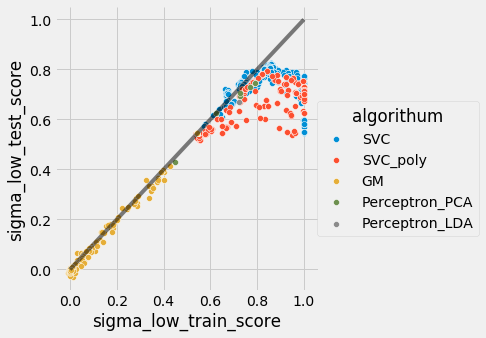

In [14]:
sns.pairplot(x_vars=["sigma_low_train_score"], y_vars=["sigma_low_test_score"], data=summary_df, hue="algorithum", size=5)
plt.plot([0,1],[0,1],c='k',alpha=0.5)
plt.show()

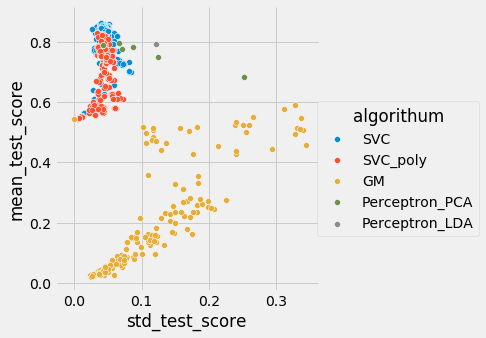

In [15]:
sns.pairplot(x_vars=["std_test_score"], y_vars=["mean_test_score"], data=summary_df, hue="algorithum", size=5)
plt.show()

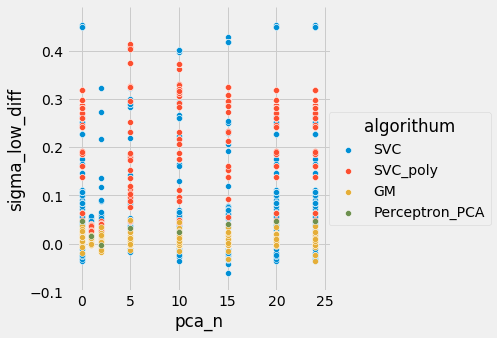

In [16]:
mod_df = cp(summary_df)
mod_df['pca_n'] = mod_df['params'].apply(lambda x: x.get('feature__n_components',np.nan))
mod_df = mod_df[~mod_df['pca_n'].isnull()]
sns.pairplot(x_vars=["pca_n"], y_vars=['sigma_low_diff'], data=mod_df, hue="algorithum", size=5)
plt.show()

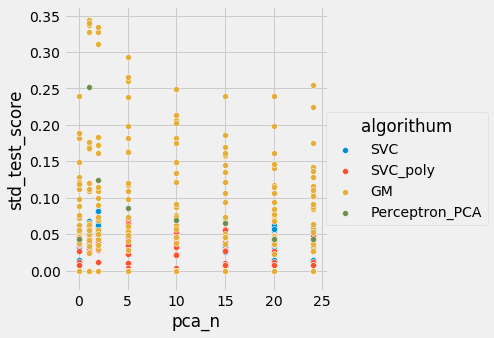

In [17]:
mod_df = cp(summary_df)
mod_df['pca_n'] = mod_df['params'].apply(lambda x: x.get('feature__n_components',np.nan))
mod_df = mod_df[~mod_df['pca_n'].isnull()]
sns.pairplot(x_vars=["pca_n"], y_vars=["std_test_score"], data=mod_df, hue="algorithum", size=5)
plt.show()

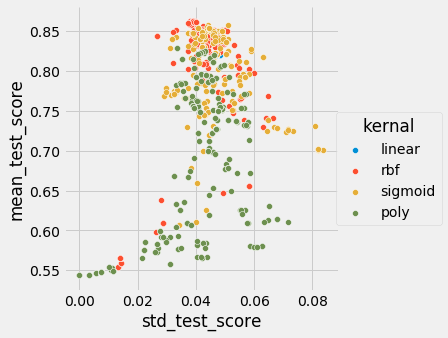

In [18]:
mod_df = cp(summary_df)
mod_df['kernal'] = mod_df['params'].apply(lambda x: x.get('classifier__kernel',np.nan))
mod_df = mod_df[~mod_df['kernal'].isnull()]
sns.pairplot(x_vars=["std_test_score"], y_vars=["mean_test_score"], data=mod_df, hue="kernal", size=5)
plt.show()

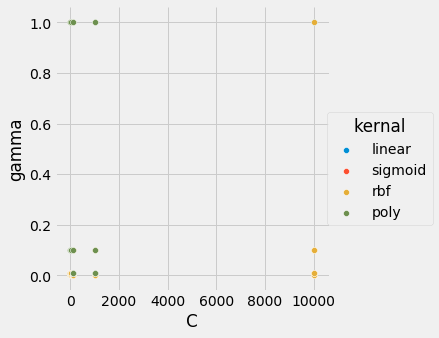

In [19]:
mod_df = cp(summary_df)
mod_df['kernal'] = mod_df['params'].apply(lambda x: x.get('classifier__kernel',np.nan))
mod_df['C'] = mod_df['params'].apply(lambda x: x.get('classifier__C',np.nan))
mod_df['gamma'] = mod_df['params'].apply(lambda x: x.get('classifier__gamma',np.nan))

mod_df = mod_df[~mod_df['kernal'].isnull()]
mod_df = mod_df[mod_df['mean_test_score']> 0.8]
sns.pairplot(x_vars=["C"], y_vars=["gamma"], data=mod_df, hue="kernal", size=5)
plt.show()

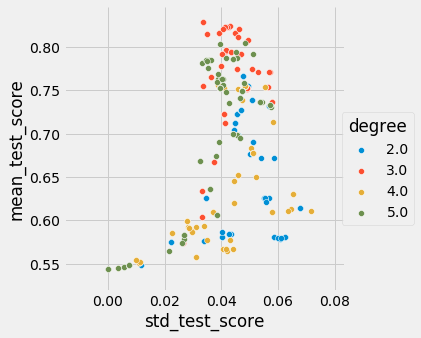

In [20]:
mod_df = cp(summary_df)
mod_df['degree'] = mod_df['params'].apply(lambda x: x.get('classifier__degree',np.nan))

sns.pairplot(x_vars=["std_test_score"], y_vars=["mean_test_score"], data=mod_df, hue="degree", size=5)
plt.show()

In [21]:
mod_df = cp(summary_df)
mod_df['kernal'] = mod_df['params'].apply(lambda x: x.get('classifier__kernel',np.nan))
mod_df['C'] = mod_df['params'].apply(lambda x: x.get('classifier__C',np.nan))
mod_df['gamma'] = mod_df['params'].apply(lambda x: x.get('classifier__gamma',np.nan))

c_curve = mod_df.groupby('C').agg({'sigma_low_test_score':np.max}).reset_index()
gamma_curve = mod_df.groupby('gamma').agg({'sigma_low_test_score':np.max}).reset_index()

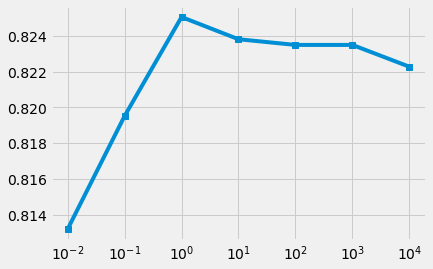

In [22]:
plt.semilogx(c_curve['C'],c_curve['sigma_low_test_score'],marker='s')
plt.show()

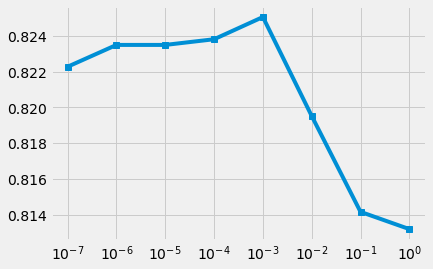

In [23]:
plt.semilogx(gamma_curve['gamma'],gamma_curve['sigma_low_test_score'],marker='s')
plt.show()

In [24]:
summary_df=summary_df.sort_values(by='sigma_low_test_score',ascending=False)
summary_df['rank'] = np.array(range(summary_df.shape[0]))

In [25]:
summary_df.groupby('algorithum').agg({'rank':np.min,'sigma_low_test_score':np.max,'params':len})

,rank,sigma_low_test_score,params
algorithum,,,
GM,1849,0.543860,192
Perceptron_LDA,1244,0.669797,1
Perceptron_PCA,867,0.744834,8
SVC,0,0.825043,1344
SVC_poly,368,0.795381,1536


In [26]:
summary_df.shape

(3081, 10)

In [27]:
# N models Trained
1+8+ 192 + 2880 + 3840

6921

In [28]:
top = 5
summary_df.iloc[0]['algorithum']


'SVC'

In [29]:
pipe = hdpo.get_paramater_grids(data_path)[summary_df.iloc[0]['algorithum']]['pipeline']
pipe.set_params(**summary_df.iloc[0]['params'] )

# pipe.set_params(classifier__class_weight={0:0.5,1:0.5})

/Users/peter/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/peter/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Pipeline(memory=None,
     steps=[('cleaner', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_pipe', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key_list=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'])), ('Imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('s...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

X = np.array(data_df.iloc[:, :-1])
y = np.array(data_df['ispos_truth'])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=10)
for train_idx, validation_idx in sss.split(X, y):
    pass


pipe.fit(data_df.iloc[train_idx],data_df.iloc[train_idx]['ispos_truth'],)
pipe.score(data_df.iloc[validation_idx],data_df.iloc[validation_idx]['ispos_truth'])


2017-11-19 07:47:31,166|heart_disease.preprocessing|DEBUG|Fit Transform passthrough  PCA
2017-11-19 07:47:31,168|heart_disease.preprocessing|DEBUG|Pass through fit, does Nothing
2017-11-19 07:47:31,170|heart_disease.preprocessing|DEBUG|Pass through transform, does Nothing
2017-11-19 07:47:31,182|heart_disease.preprocessing|DEBUG|Pass through transform, does Nothing


0.8771929824561403

In [31]:
is_test = np.zeros(data_df.shape[0])

In [32]:
is_test[validation_idx] = 1

In [33]:
data_df['predictions'] = pipe.predict(data_df)
data_df['is_test'] = is_test
data_df['is_error'] = data_df['predictions']!=data_df['ispos_truth']

2017-11-19 07:47:31,278|heart_disease.preprocessing|DEBUG|Pass through transform, does Nothing


In [34]:
np.abs(data_df.corr())["is_error"].sort_values()

thal           0.001424
slope          0.004256
predictions    0.008820
restecg        0.011145
ca             0.012132
is_test        0.015036
oldpeak        0.019212
thalach        0.021210
trestbps       0.021635
chol           0.027948
fbs            0.038643
age            0.040530
ispos_truth    0.057973
cp             0.108349
exang          0.120340
sex            0.155953
is_error       1.000000
Name: is_error, dtype: float64

In [35]:
np.abs(data_df.corr())["sex"].sort_values()

is_test        0.001731
fbs            0.002656
cp             0.003674
ca             0.006487
restecg        0.026442
thalach        0.044649
age            0.066618
slope          0.071682
trestbps       0.084269
oldpeak        0.088574
exang          0.106640
is_error       0.155953
chol           0.256004
ispos_truth    0.265731
predictions    0.273127
thal           0.317346
sex            1.000000
Name: sex, dtype: float64

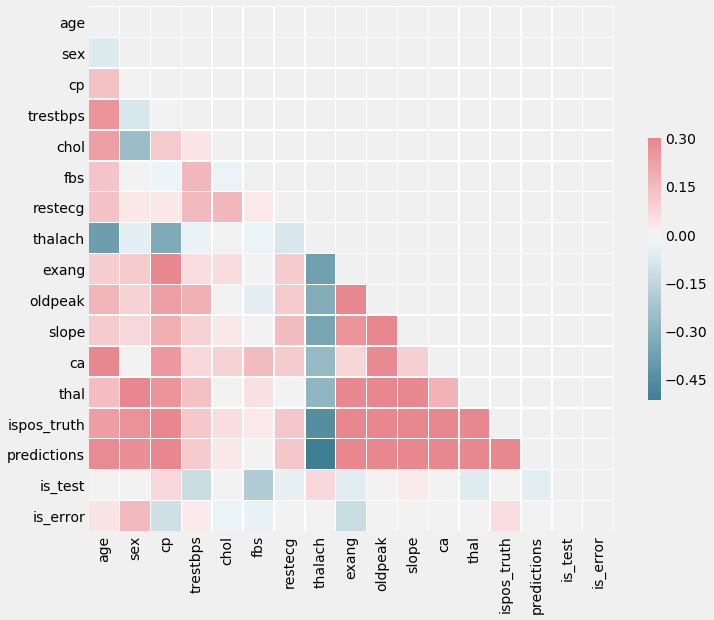

In [36]:
hdp.correlation_matrix(data_df)
plt.show()

In [37]:
error_df = data_df[data_df['is_error']]
error_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ispos_truth,predictions,is_test,is_error
pat_id,,,,,,,,,,,,,,,,,
124,65.0,1.0,1.0,138.0,282.0,1.0,2.0,174.0,0.0,1.4,2.0,1.0,3.0,True,False,0.0,True
33,59.0,1.0,4.0,135.0,234.0,0.0,0.0,161.0,0.0,0.5,2.0,0.0,7.0,False,True,0.0,True
274,59.0,1.0,1.0,134.0,204.0,0.0,0.0,162.0,0.0,0.8,1.0,2.0,3.0,True,False,0.0,True
10,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0,False,True,0.0,True
92,62.0,1.0,3.0,130.0,231.0,0.0,0.0,146.0,0.0,1.8,2.0,3.0,7.0,False,True,0.0,True
66,60.0,1.0,3.0,140.0,185.0,0.0,2.0,155.0,0.0,3.0,2.0,0.0,3.0,True,False,1.0,True
32,64.0,1.0,3.0,140.0,335.0,0.0,0.0,158.0,0.0,0.0,1.0,0.0,3.0,True,False,1.0,True
176,52.0,1.0,4.0,108.0,233.0,1.0,0.0,147.0,0.0,0.1,1.0,3.0,7.0,False,True,0.0,True
184,60.0,0.0,4.0,158.0,305.0,0.0,2.0,161.0,0.0,0.0,1.0,0.0,3.0,True,False,0.0,True


In [38]:
data_df.shape

(227, 17)

In [39]:
np.sum(data_df['ispos_truth'])/data_df.shape[0]

0.45814977973568283

In [40]:
np.sum(error_df['ispos_truth'])/error_df.shape[0]

0.53846153846153844

In [41]:
error_df.shape[0]

26

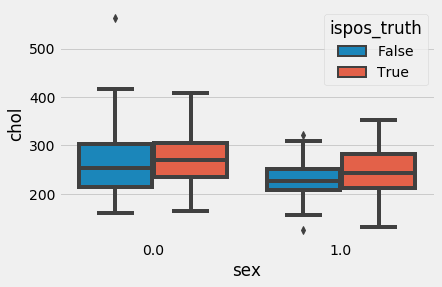

In [42]:
sns.boxplot(x="sex", y="chol", data=data_df, hue="ispos_truth")
plt.show()

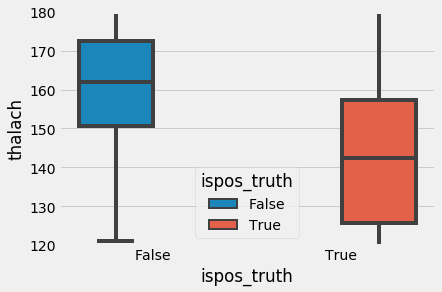

In [43]:
sns.boxplot(x="ispos_truth", y="thalach", data=data_df, hue="ispos_truth")
plt.ylim([120,180])
plt.show()

In [44]:
sns.stripplot(x="sex", y="exang", data=data_df, hue='ispos_truth', jitter=True)

test = data_df.groupby(['sex','exang']).agg({'ispos_truth':np.sum,'thalach':len})

test.columns = ['numPos','total']
test['frac'] = test['numPos']/test['total']
test

numPos  total      frac
sex exang                         
0.0 0.0       9.0   55.0  0.163636
    1.0      10.0   17.0  0.588235
1.0 0.0      42.0  102.0  0.411765
    1.0      43.0   53.0  0.811321

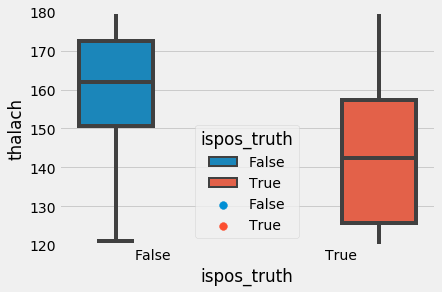

In [45]:
sns.boxplot(x="ispos_truth", y="thalach", data=data_df, hue="ispos_truth")
plt.ylim([120,180])
plt.show()

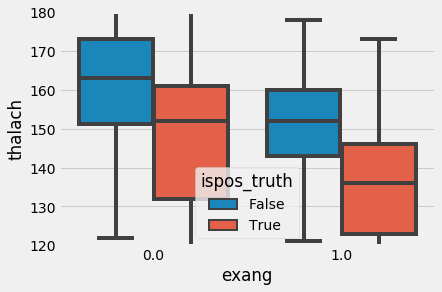

In [46]:
sns.boxplot(x="exang", y="thalach", data=data_df, hue="ispos_truth")
plt.ylim([120,180])
plt.show()

In [47]:
# Scatter by Gender 
gender_map = {0:'female',1:'male'}
data_df['sex'].apply(lambda x:gender_map[x])

truth_map = {False:'neg',True:'pos'}
data_df['ispos_truth'].apply(lambda x:truth_map[x])

data_df['comba'] = data_df['ispos_truth'].apply(lambda x:gender_map[x]) + data_df['sex'].apply(lambda x:truth_map[x])

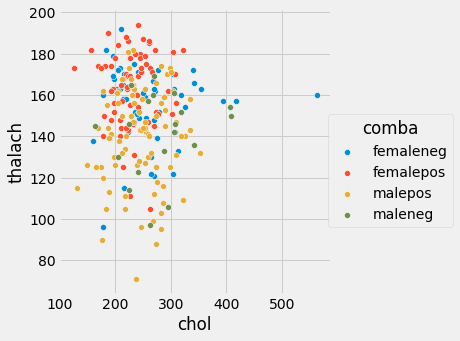

In [48]:
sns.pairplot(x_vars=["chol"], y_vars=["thalach"], data=data_df, hue="comba", size=5)
plt.show()

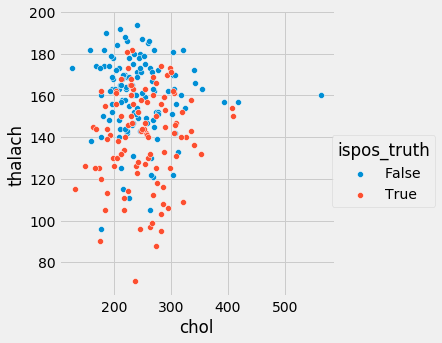

In [49]:
sns.pairplot(x_vars=["chol"], y_vars=["thalach"], data=data_df, hue="ispos_truth", size=5)
plt.show()

In [50]:
diff_by_gender = data_df.groupby('sex').agg([np.mean, np.std]).transpose()

In [51]:
diff_by_gender['diff']=np.abs((diff_by_gender[0]-diff_by_gender[1])/(diff_by_gender[0]+diff_by_gender[0]))
diff_by_gender.sort_values(by='diff',ascending=False)
# diff_by_gender

,sex,0.0,1.0,diff
is_error,mean,0.041667,0.148387,1.280645
predictions,mean,0.250000,0.541935,0.583871
ispos_truth,mean,0.263889,0.548387,0.539049
is_error,std,0.201229,0.356636,0.386145
exang,mean,0.236111,0.341935,0.224099
chol,std,67.623972,43.341995,0.179537
thal,mean,3.887324,5.220779,0.171513
oldpeak,mean,0.904167,1.132903,0.126490
thalach,std,19.502257,24.364946,0.124670
cp,std,0.839181,1.007429,0.100245


In [52]:
feature_in = 'thalach'

In [53]:
np.mean(data_df[data_df['sex']==1][feature_in])

149.80645161290323

In [54]:
def add_gender_based_feature(data_df, feature_in):
    male_mean = np.mean(data_df[data_df['sex']==1][feature_in])
    male_std = np.std(data_df[data_df['sex']==1][feature_in])

    female_mean = np.mean(data_df[data_df['sex']==0][feature_in])
    female_std = np.std(data_df[data_df['sex']==0][feature_in])

    out = np.zeros_like(data_df[feature_in])

    for idx, (sex, feat) in enumerate(zip(data_df['sex'],data_df[feature_in])):
        if sex == 1:
            out[idx] = (feat-male_mean)/male_std
        elif sex==0:
            out[idx] = (feat-female_mean)/female_std
        else:
            raise(ValueError('Unknown Gender {}'.format(sex)))  
            
    return out

In [55]:
data_df['gender_chol'] = add_gender_based_feature(data_df, 'chol')
data_df['gender_thalach'] = add_gender_based_feature(data_df, 'thalach')

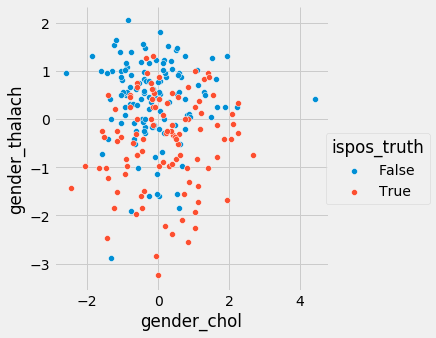

In [56]:
sns.pairplot(x_vars=["gender_chol"], y_vars=["gender_thalach"], data=data_df, hue="ispos_truth", size=5)
plt.show()

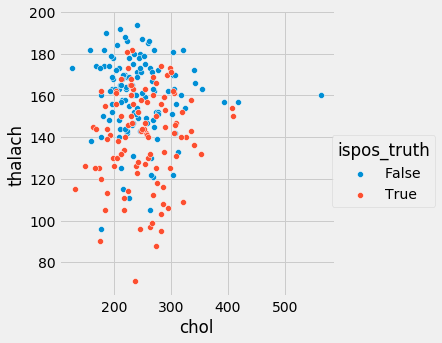

In [57]:
sns.pairplot(x_vars=["chol"], y_vars=["thalach"], data=data_df, hue="ispos_truth", size=5)
plt.show()

In [58]:
out_df = cp(data_df)

for feat in ['exang']:
    out_df[feat]=add_gender_based_feature(data_df,feat)
out_df['ispos_truth'] = list(data_df['ispos_truth'])


# out_df['exang'] = data_df['exang']*data_df['sex']
# out_df['sex'] = data_df['exang']*(1-data_df['sex'])

In [59]:
pipe = hdpo.get_paramater_grids(data_path)[summary_df.iloc[0]['algorithum']]['pipeline']
pipe.set_params(**summary_df.iloc[0]['params'] )

from sklearn.model_selection import StratifiedShuffleSplit

X = np.array(out_df.iloc[:, :-1])
y = np.array(out_df['ispos_truth'])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=10)
for train_idx, validation_idx in sss.split(X, y):
    pass


pipe.fit(out_df.iloc[train_idx],out_df.iloc[train_idx]['ispos_truth'],)
pipe.score(out_df.iloc[validation_idx],out_df.iloc[validation_idx]['ispos_truth'])

/Users/peter/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/peter/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
2017-11-19 07:47:35,189|hear

0.8771929824561403

In [60]:
0.8596491228070176

0.8596491228070176

In [61]:
out_df['predictions'] = pipe.predict(out_df)
out_df['is_error'] = data_df['predictions']!=data_df['ispos_truth']

2017-11-19 07:47:35,259|heart_disease.preprocessing|DEBUG|Pass through transform, does Nothing


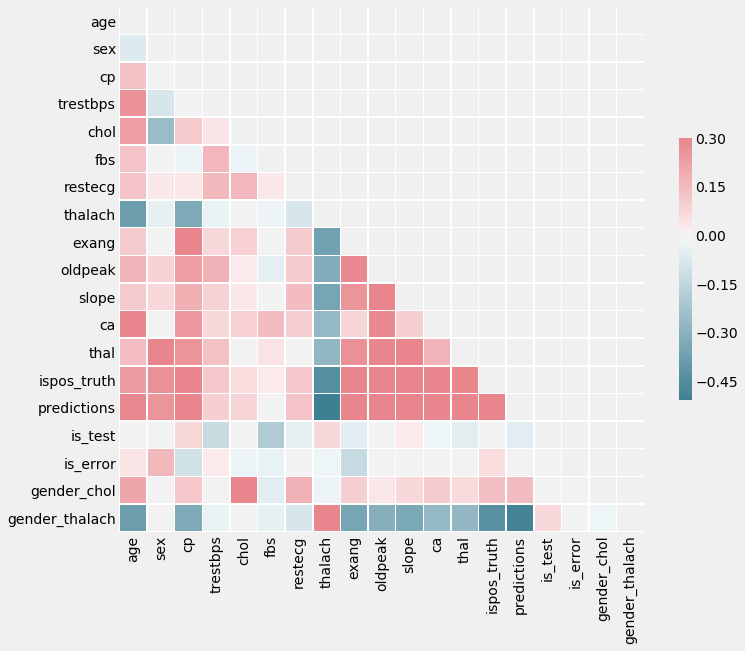

In [62]:
hdp.correlation_matrix(out_df)
plt.show()

In [63]:
np.abs(out_df.corr()['is_error']).sort_values(ascending=False)

is_error          1.000000
sex               0.155953
exang             0.135767
cp                0.108349
ispos_truth       0.057973
age               0.040530
fbs               0.038643
chol              0.027948
trestbps          0.021635
thalach           0.021210
oldpeak           0.019212
gender_thalach    0.016451
is_test           0.015036
ca                0.012132
restecg           0.011145
predictions       0.005630
slope             0.004256
thal              0.001424
gender_chol       0.000659
Name: is_error, dtype: float64

In [64]:
np.abs(data_df.corr()['is_error']).sort_values(ascending=False)

is_error          1.000000
sex               0.155953
exang             0.120340
cp                0.108349
ispos_truth       0.057973
age               0.040530
fbs               0.038643
chol              0.027948
trestbps          0.021635
thalach           0.021210
oldpeak           0.019212
gender_thalach    0.016451
is_test           0.015036
ca                0.012132
restecg           0.011145
predictions       0.008820
slope             0.004256
thal              0.001424
gender_chol       0.000659
Name: is_error, dtype: float64